- Ownership data and fire perimeters have been projected to EPSG 4326. Intersections of these areas are projected to EPSG 3857 for area calculation and then plotting on a map. If I did this again, I would keep everything in 3857. 

In [108]:
import json
import pandas as pd
import geopandas as gpd
import numpy as np
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pickle
import pyproj
from shapely.geometry import shape
from shapely.geometry import Polygon
from shapely.ops import transform
from functools import partial
import contextily as ctx
import subprocess
from scipy import interpolate

In [8]:
# Collect archived beachie creek fire perimeters
# https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/Archived_Wildfire_Perimeters2/FeatureServer/0/query?where=IncidentName%20%3D%20%27BEACHIE%20CREEK%27&outFields=*&outSR=4326&f=geojson

beachie_perimeters = gpd.read_file('fire_perimeters/beachie_archives_09_22.geojson')

In [6]:
# Collect ownership layers (vectorized in QGIS)
# https://www.fs.usda.gov/rds/archive/Catalog/RDS-2020-0044

tribal = gpd.read_file('ownerships/tribal_dissolved.geojson')
federal = gpd.read_file('ownerships/federal_dissolved.geojson')
state = gpd.read_file('ownerships/state_dissolved.geojson')
local = gpd.read_file('ownerships/local_dissolved.geojson')
corporate = gpd.read_file('ownerships/corporate_dissolved.geojson')
timo = gpd.read_file('ownerships/timo_reit_dissolved.geojson')
private = gpd.read_file('ownerships/private_other_dissolved.geojson')

# Collect USFS "Timber Production Primary Emphasis" land suitability class
# https://apps.fs.usda.gov/arcx/rest/services/EDW/EDW_TimberHarvest_01/MapServer/8/query?where=ADMIN_FOREST_CODE%20%3D%20%2706%27%20AND%20ADMIN_REGION_CODE%20%3D%20%2706%27%20AND%20LAND_SUITABILITY_CLASS_CODE%20%3D%20%27500%27&outFields=*&outSR=4326&f=geojson
usfs_files = ['ownerships/hood_2.geojson', 'ownerships/willamette_1.geojson', 'ownerships/willamette_2.geojson', 'ownerships/willamette_3.geojson', 'ownerships/willamette_4.geojson', 'ownerships/willamette_5.geojson', 'ownerships/willamette_6.geojson']
usfs_timber = gpd.read_file('ownerships/hood_1.geojson')
for usfs_file in usfs_files:
    usfs_timber = usfs_timber.append(gpd.read_file(usfs_file))
    
ownerships = { 'tribal': tribal, 'federal': federal, 'state': state, 'local': local, 'corporate': corporate,
               'timo': timo, 'private': private , 'usfs_timber': usfs_timber}

In [10]:
# Find intersections of fire area and each ownership area
# this takes a while

intersections = {}

for key in ownerships:
    intersection = {}
    for i in range(len(beachie_perimeters)):
        perimeter_date = beachie_perimeters.iloc[i].GDB_TO_DATE
        perimeter = gpd.GeoDataFrame({'geometry': [beachie_perimeters.iloc[i].geometry]})
        intersection[perimeter_date] = gpd.overlay(perimeter, ownerships[key], how='intersection')
    
    intersections[key] = intersection
    print(f'{key} done')

tribal done
federal done
state done
local done
corporate done
timo done
private done
usfs_timber done


In [146]:
# Save interesctions
pickle.dump(intersections, open("intersections.p", "wb"))

In [3]:
# Load intersections
intersections = pickle.load( open( "intersections.p", "rb" ) )

In [148]:
# Find areas of intersection in meters squared
# this takes a while

proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
               pyproj.Proj(init='epsg:3857'))

intersection_areas = {}
for ownership in ownerships:
    ownership_area = {}
    for time in beachie_perimeters.GDB_TO_DATE:
        projected_area = 0
        for geo in intersections[ownership][time].geometry:
            projected_area += transform(proj, geo).area
        ownership_area[time] = projected_area
    intersection_areas[ownership] = ownership_area
    print(f'{ownership} done')

tribal done
federal done
state done
local done
corporate done
timo done
private done
usfs_timber done


In [149]:
# Save intersection areas
pickle.dump(intersection_areas, open("intersection_areas.p", "wb"))

In [4]:
# Load intersection areas
intersection_areas = pickle.load( open( "intersection_areas.p", "rb" ) )

In [9]:
# Convert intersection areas from meters squared to acres
intersection_areas_acres = intersection_areas
for ownership in ownerships:
    for time in beachie_perimeters.GDB_TO_DATE:
        intersection_areas_acres[ownership][time] *= 0.000247105

In [10]:
# Tally timber, non-timber acres
timber_acres = []
non_timber_acres = []
for time in beachie_perimeters.GDB_TO_DATE:
    non_timber_acres.append(intersection_areas['federal'][time] - intersection_areas['usfs_timber'][time])
    timber_acres.append(intersection_areas['usfs_timber'][time] + intersection_areas['state'][time] + intersection_areas['private'][time] + intersection_areas['corporate'][time] + intersection_areas['timo'][time])

In [137]:
# Interpolate for animation
times = np.linspace(beachie_perimeters.iloc[0].GDB_TO_DATE, beachie_perimeters.iloc[-4].GDB_TO_DATE, 100)
non_timber_acres_anim = []
timber_acres_anim = []

non_timber_acres_anim = interpolate.interp1d(beachie_perimeters.GDB_TO_DATE, non_timber_acres, kind='slinear')(times)
timber_acres_anim = interpolate.interp1d(beachie_perimeters.GDB_TO_DATE, timber_acres, kind='slinear')(times)

In [138]:
# Radial interpolation of timber/non-timber for animation
timber_polys = []
private_polys = []
corporate_polys = []
timo_polys = []
state_polys = []
usfs_timber_polys = []
non_timber_polys = []


boundary = gpd.GeoDataFrame(geometry=[beachie_perimeters.iloc[0].geometry])
for n in range(len(times)-1):
    i = 0
    prev_poly = beachie_perimeters.iloc[0]
    while beachie_perimeters.iloc[i].GDB_TO_DATE <= times[n]:
        prev_poly = beachie_perimeters.iloc[i]
        i += 1
    next_poly = beachie_perimeters.iloc[i]
    
    ratio = (times[n] - prev_poly.GDB_TO_DATE + 1)/(next_poly.GDB_TO_DATE - prev_poly.GDB_TO_DATE) 
    centroid = prev_poly.geometry.centroid
    radius = ratio*max(abs(centroid.x - next_poly.geometry.bounds[0]), abs(centroid.y - next_poly.geometry.bounds[1]))
    boundary_addition_points = []
    for theta in np.linspace(0, 2*np.pi, 1000):
        boundary_addition_points.append((centroid.x + radius*np.cos(theta), centroid.y + radius*np.sin(theta)))
    boundary_addition = Polygon(boundary_addition_points)
    
    boundary_addition_gdf = gpd.GeoDataFrame(geometry=[boundary_addition])
    try:
        boundary = gpd.overlay(boundary, boundary_addition_gdf, how='union')
    except:
        pass
    
    if len(intersections['federal'][next_poly.GDB_TO_DATE].geometry) > 0:
        non_timber_polys.append(gpd.overlay(boundary, intersections['federal'][next_poly.GDB_TO_DATE], how='intersection'))
    else:
        non_timber_polys.append(gpd.GeoDataFrame(geometry=[]))
    
    if len(intersections['private'][next_poly.GDB_TO_DATE].geometry) > 0:
        private_polys.append(gpd.overlay(boundary, intersections['private'][next_poly.GDB_TO_DATE], how='intersection'))
    else:
        private_polys.append(gpd.GeoDataFrame(geometry=[]))
        
    if len(intersections['corporate'][next_poly.GDB_TO_DATE].geometry) > 0:
        corporate_polys.append(gpd.overlay(boundary, intersections['corporate'][next_poly.GDB_TO_DATE], how='intersection'))
    else:
        corporate_polys.append(gpd.GeoDataFrame(geometry=[]))
        
    if len(intersections['timo'][next_poly.GDB_TO_DATE].geometry) > 0:
        timo_polys.append(gpd.overlay(boundary, intersections['timo'][next_poly.GDB_TO_DATE], how='intersection'))
    else:
        timo_polys.append(gpd.GeoDataFrame(geometry=[]))

    if len(intersections['state'][next_poly.GDB_TO_DATE].geometry) > 0:
        state_polys.append(gpd.overlay(boundary, intersections['state'][next_poly.GDB_TO_DATE], how='intersection'))
    else:
        state_polys.append(gpd.GeoDataFrame(geometry=[]))
        
    if len(intersections['usfs_timber'][next_poly.GDB_TO_DATE].geometry) > 0:
        usfs_timber_polys.append(gpd.overlay(boundary, intersections['usfs_timber'][next_poly.GDB_TO_DATE], how='intersection'))
    else:
        usfs_timber_polys.append(gpd.GeoDataFrame(geometry=[]))
        
    print(n/len(times))

0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.7


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.71


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.72


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.73


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.74


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.75


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.76


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.77


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.78


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.79


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.8


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.81


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.82


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.83


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.84


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.85


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.86


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.87


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.88


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.89


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.9


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.91


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.92


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.93


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.94


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.95


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.96


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.97


TopologyException: found non-noded intersection between LINESTRING (-122.372 44.9753, -122.372 44.9749) and LINESTRING (-122.372 44.9749, -122.372 44.9753) at -122.37193467503683 44.975267331760442


0.98


/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/ian/.local/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The G

KeyboardInterrupt: 

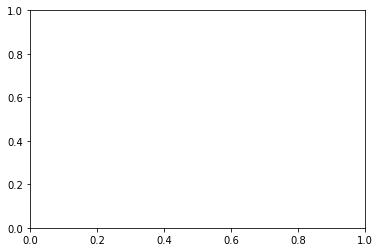

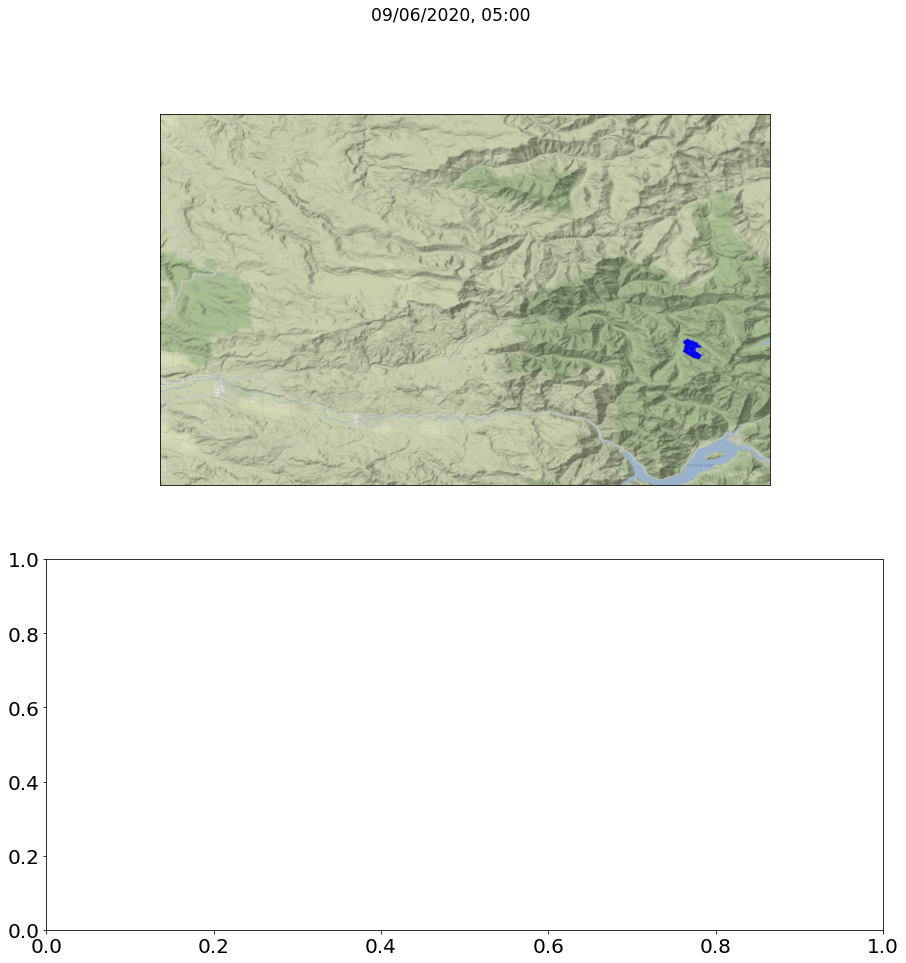

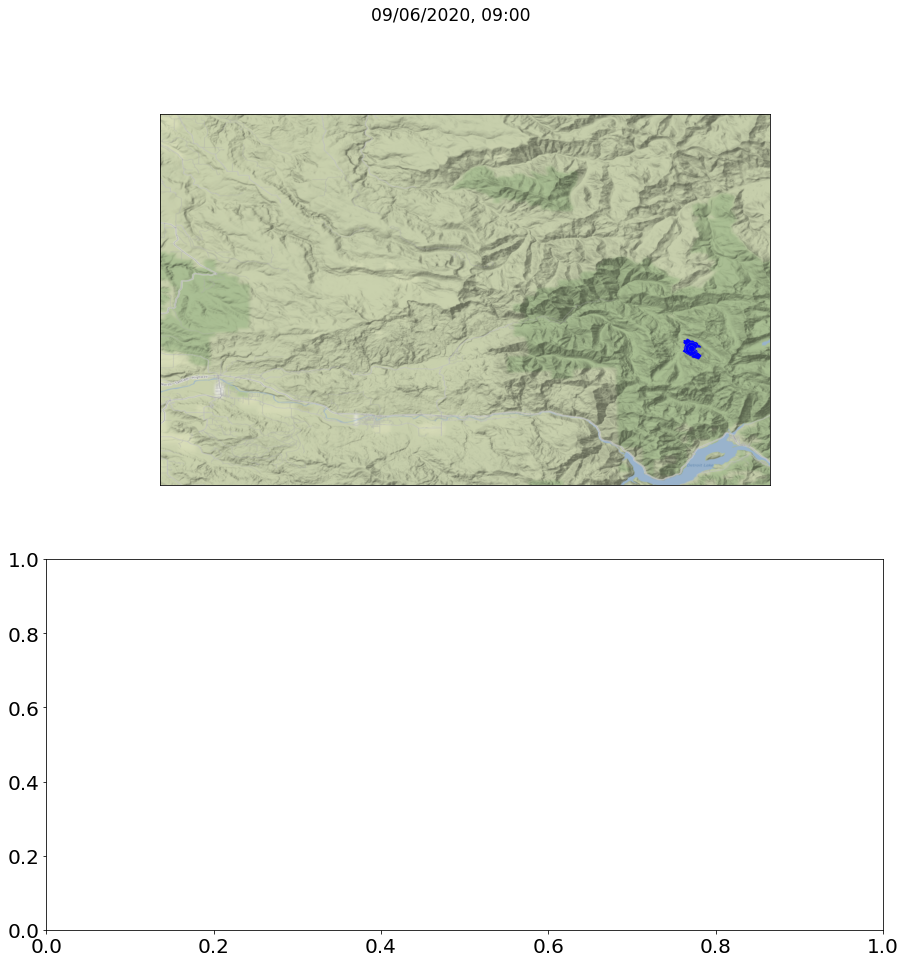

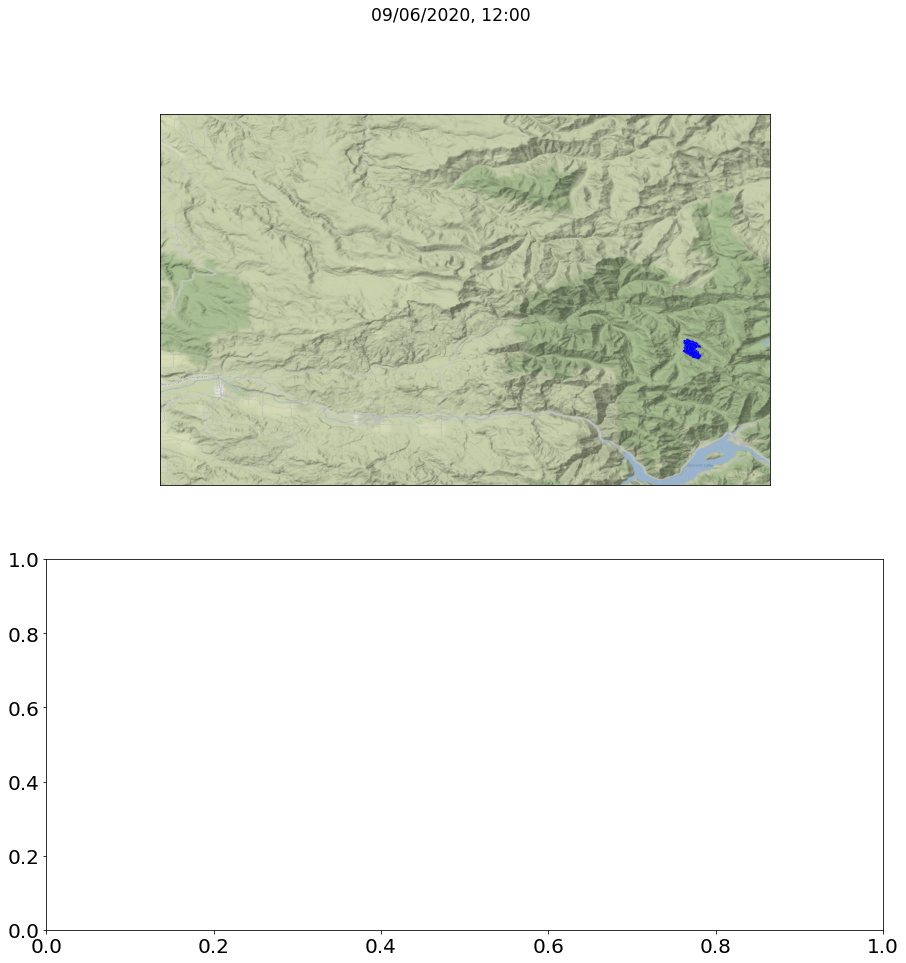

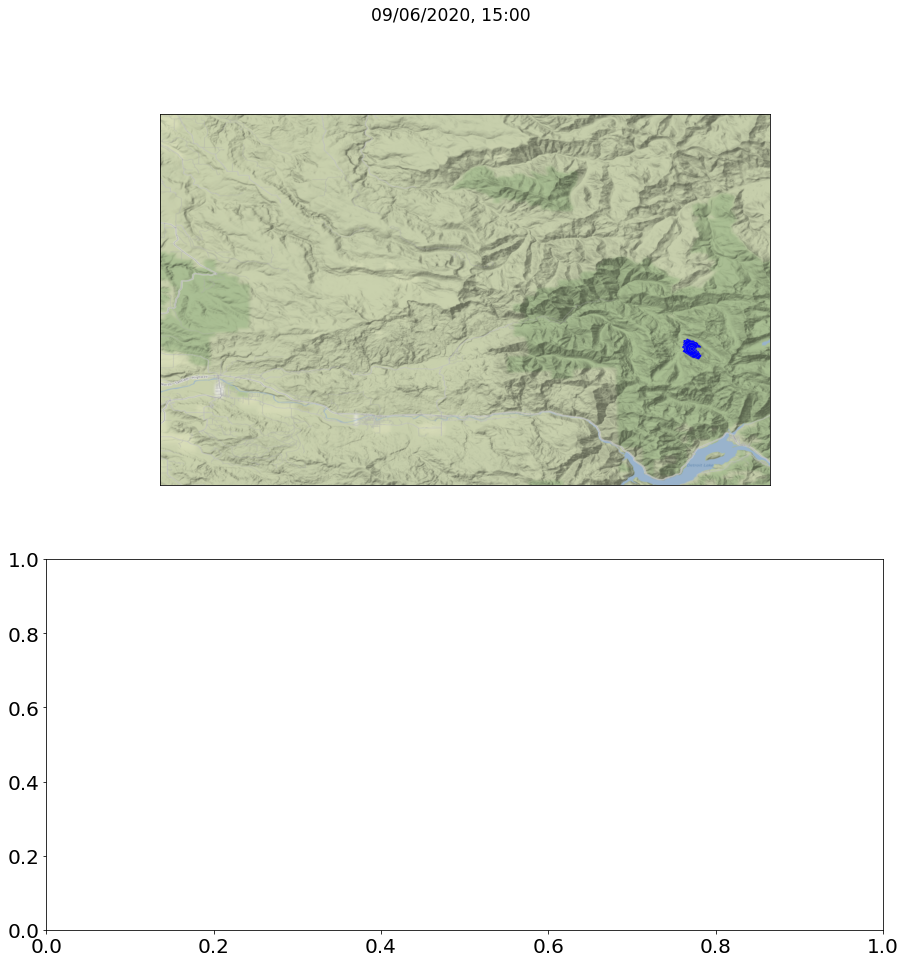

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Error in callback <function flush_figures at 0x7efd7b30fae8> (for post_execute):
Traceback (most recent call last):
  File "/home/ian/.local/lib/python3.7/site-packages/IPython/core/events.py", line 88, in trigger
    func(*args, **kwargs)
  File "/home/ian/.local/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py", line 117, in flush_figures
    return show(True)
  File "/home/ian/.local/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py", line 39, in show
    metadata=_fetch_figure_metadata(figure_manager.canvas.figure)
  File "/home/ian/.local/lib/python3.7/site-packages/IPython/core/display.py", line 306, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
  File "/home/ian/.local/lib/python3.7/site-packages/IPython/core/formatters.py", line 180, in format
    data = formatter(obj)
  File "</home/ian/.local/lib/python3.7/site-packages/decorator.py:decorator-gen-9>", line 2, in __call__
  File "/home/ian/.local/lib/python3.7/site

KeyboardInterrupt: 

In [140]:
# Create animated plot
plt.figure()
xmin, ymin, xmax, ymax = beachie_perimeters.iloc[-1].geometry.bounds

for n in range(1, len(times)-1):
    plt.cla()
    fig, axes = plt.subplots(2,1, figsize=(15, 15))
    
    i = 1
    time = times[0]
    while beachie_perimeters.iloc[i-1].GDB_TO_DATE < times[n]:
        time = beachie_perimeters.iloc[i].GDB_TO_DATE
        i += 1
    
    axes[0].set_xlim(xmin, xmax)
    axes[0].set_ylim(ymin, ymax)
    axes[0].get_xaxis().set_ticks([])
    axes[0].get_yaxis().set_ticks([])
    
    non_timber_polys[n].plot(ax=axes[0], color='b')
    usfs_timber_polys[n].plot(ax=axes[0], color='r')
    private_polys[n].plot(ax=axes[0], color='r')
    corporate_polys[n].plot(ax=axes[0], color='r')
    timo_polys[n].plot(ax=axes[0], color='r')
    state_polys[n].plot(ax=axes[0], color='r')
    
    ctx.add_basemap(axes[0], crs={'init': 'epsg:4326'}, url=ctx.sources.ST_TERRAIN)

    readable_times = []
    for time in times[:n-1]:
        readable_times.append(datetime.fromtimestamp(time/1000, timezone.utc).strftime("%m/%d"))
    axes[1].plot(times[:n-1], non_timber_acres_anim[:n-1], color='b')
    axes[1].plot(times[:n-1], timber_acres_anim[:n-1], color='r')
    axes[1].set_xticklabels(readable_times)
    axes[1].tick_params(axis='both', labelsize=20)
    axes[1].set_ylabel('Acres Burned', fontsize='xx-large')
    axes[1].legend(['Not managed primarily for timber production', 'Managed primarily for timber production'], loc='upper left', fontsize='xx-large')
    
#     axes[2].pie([timber_acres_anim[n], non_timber_acres_anim[n]], labels=['Timber', 'Non-Timber'], colors=['r', 'b'])
    
    fig.suptitle(datetime.fromtimestamp(times[n]/1000, timezone.utc).strftime("%m/%d/%Y, %H:00"), fontsize='xx-large')
    plt.savefig('beachie_frames/frame%03d.png' %n)

In [142]:
subprocess.run("ffmpeg -framerate 15 -i ./beachie_frames/frame%03d.png beachie.mp4", shell=True, capture_output=True)

CompletedProcess(args='ffmpeg -framerate 15 -i ./beachie_frames/frame%03d.png beachie.mp4', returncode=0, stdout=b'', stderr=b"ffmpeg version 4.1.6-1~deb10u1 Copyright (c) 2000-2020 the FFmpeg developers\n  built with gcc 8 (Debian 8.3.0-6)\n  configuration: --prefix=/usr --extra-version='1~deb10u1' --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr -

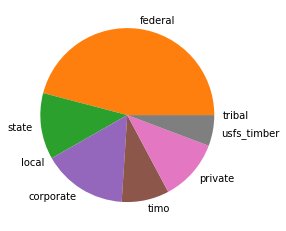

In [75]:
# Plot acres burned per category
latest_time = beachie_perimeters.iloc[9].GDB_TO_DATE

labels = list(ownerships.keys())
acres = []
for label in labels:
    acres.append(np.sum(intersections[label][latest_time].area))

acres = np.asarray(acres)
acres = acres / np.sqrt(np.sum(acres**2))
plt.pie(acres, labels=labels)
plt.show()